# Preferential Attachment from Epistemic Space


Importing required libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output

Define parameters of the model

In [2]:
number_of_authors=100
initial_connections=10
time_steps=100
attempt_per_time_step=10



Function to initialize the epistemic space with random values

In [3]:
def initialize_epistemic_space(number_of_authors):
    #epsitemic_space=np.zeros(number_of_authors,dtype=float)
    epistemic_space=[]
    for i in range(number_of_authors):
        #epsitemic_space[i]=[np.random.random(),np.random.random()]
        epistemic_space.append([np.random.random(),np.random.random()])
        
    return(epistemic_space)




Function to initialize the network with initial edges

In [4]:
def initialize_network(number_of_authors,initial_connections):
    G = nx.erdos_renyi_graph(number_of_authors,0)
    nodes = list(G.nodes())
    for i in range(initial_connections):
        node1,node2=np.random.choice(nodes,size=2)
        G.add_edge(node1,node2)
    return(G)



Function to return degree of each node of a network

In [5]:
# def list_degrees(G):
#     degrees=np.zeros(G.number_of_nodes())
#     for i in range(G.number_of_nodes()):
#         degrees[i] = G.degree(i)
#     return(degrees)  

def list_degrees(G):
    nodes=list(G.nodes())
    return(np.array([G.degree(node) for node in nodes]))

Function that executes the W model(where we choose nodes which minimize the epistemic distance)
We choose 1 node at random and then find a node among 10 randomly chosen nodes that has the minimum epistemic distance from the chosen node

In [6]:

def W_model(epistemic_space,G):
    
    nodes = list(G.nodes())
    node1=np.random.choice(nodes,size=1)
    nodes.remove(node1)
    nodes2=np.random.choice(nodes,size=10)
    distances=[]
    point1=np.array([epistemic_space[node1[0]][0],epistemic_space[node1[0]][1]])
    for j in range(len(nodes2)):
        

        
        point2=np.array([epistemic_space[j][0],epistemic_space[j][1] ])
        dist = np.linalg.norm(point1 - point2)
        distances.append(dist)
        
    return(node1[0],nodes2[np.where(distances==min(distances))[0][0]])

Function that executes the P model(where we choose nodes which maximizes mean prestige) We choose 1 node at random with $probabilty(node) = \frac{degree(node)}{Sum(degrees)}$ 
Then find a node among 10 randomly chosen nodes that has the highest degree

In [155]:

def P_model(G):
    nodes = list(G.nodes())
    degrees = list_degrees(G)
    node1=np.random.choice(nodes)
    #node1=np.random.choice(nodes)
    nodes.remove(node1)
    nodes2=np.random.choice(nodes,size=10)
    return(node1,nodes2[np.where(degrees[nodes2]==max(degrees[nodes2]))[0][0]])

Function that updates epistemic coverage of each publication

In [8]:
def calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage):
    
    m1=G.degree(node1)
    m2=G.degree(node2)
    x1=epistemic_space[node1][0]
    x2=epistemic_space[node2][0]
    y1=epistemic_space[node1][1]
    y2=epistemic_space[node2][1]
    
    point1=float((m1*x1 + m2*x2)/(m1+m2) )
    point2=float((m1*y1 + m2*y2)/(m1+m2))
    
    epistemic_coverage.append([point1,point2])

Function that calculates the acceptance probability of publication of 2 selected authors

In [9]:
def acceptance_Prob_Publication(G,node1,node2):
    degrees = list_degrees(G)
    return ((G.degree(node1) + G.degree(node2))/(degrees.sum()))

Function that evolves the network by selecting authors by P model

In [242]:


def evolve_network_PP(G,epistemic_space,time_steps,attempt_per_time_step):
    epistemic_coverage=[]
    for t in range(time_steps):
        b=0
        while(b<10):
            node1,node2 = P_model(G)
            if np.random.random() < acceptance_Prob_Publication(G,node1,node2) :
                G.add_edge(node1,node2)
                calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
                b=b+1
    return(epistemic_coverage)




Function that evolves the network by selecting authors by W model

In [129]:
def evolve_network_WP(G,epistemic_space,time_steps,attempt_per_time_step):
    epistemic_coverage=[]
    for t in range(time_steps):
        b=0
        while(b!=10):
            node1,node2 = W_model(epistemic_space,G)
            if(G.has_edge(node1,node2)==False):
                if np.random.random() < acceptance_Prob_Publication(G,node1,node2) :
                    G.add_edge(node1,node2)
                    calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
                    b=b+1
                
    return(epistemic_coverage)

Function to draw network sturcture of given graph

In [12]:
def draw_graph(G):
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, node_size=50, font_size=8)
    plt.show()


Function to plot degree distribution

In [13]:
def plot_degree_distribution(G):
    degrees = dict(G.degree())

    # Calculate the degree distribution
    degree_distribution = [list(degrees.values()).count(i) for i in range(max(degrees.values()) + 1)]

    # Normalize the degree distribution to obtain probabilities
    total_nodes = len(G.nodes())
    degree_distribution_prob = [count / total_nodes for count in degree_distribution]

    # Plot the degree distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_distribution_prob)), degree_distribution_prob, width=0.8, color='b', alpha=0.7)
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree Distribution of the Network')
    plt.xticks(range(len(degree_distribution_prob)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
        

Function to plot the number of authorships for each author in ascending order

In [169]:
def plot_sorted_degree_distribution(G):
    plt.figure(figsize=(10, 6))
    plt.plot(np.sort(list_degrees(G)))
    plt.xlabel('Authors')
    plt.ylabel('Degree')
    plt.title('Degree Distribution with sorted authorships')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


Function to plot heat map of epsitemic coverage of published papers

In [14]:
def plot_epistemic_coverage(epistemic_coverage):
    ec=epistemic_coverage
    x=np.zeros(len(ec))
    y=np.zeros(len(ec))

    for i in range(len(ec)):
        x[i]=ec[i][1]
        y[i]=ec[i][0]
    
    plt.hist2d(x,y)

Function to show the time evolution of network simulation

In [15]:
def run_network_simulation(G,epistemic_space,time_steps,attempt_per_time_step):
    

    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    for frame in range(time_steps):
        evolve_network_WP(G,epistemic_space, 1, attempt_per_time_step)

       
        clear_output(wait=True)
        nx.draw(G, pos=pos, with_labels=True, node_size=50, font_size=8)
        plt.title(f'Time Step: {frame}')
        plt.show()


Function to display the graph in Epistemic Space

In [196]:
def draw_network_in_epistemic_space(G,epistemic_space):
    coordinates =epistemic_space
    pos = {i: (coordinates[i][0], coordinates[i][1]) for i in range(len(coordinates))}
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)


    nx.draw(G, pos, with_labels=True, node_size=100, node_color='lightblue', font_size=16, font_color='black', font_weight='bold', edge_color='gray')
    plt.title('Authors in Epistemic Space')
    plt.show()

## WP Model

Collaboration depends upon Epistemic interests and publication on mean prestige

Initializing the network

In [132]:
G=initialize_network(number_of_authors,initial_connections)

In [133]:
list_degrees(G)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0])

Initializing epsitemic space

In [134]:
epistemic_space=initialize_epistemic_space(number_of_authors)


Evolving the network using WP model to calculate epistemic coverage

In [135]:

epistemic_coverage=evolve_network_WP(G,epistemic_space,time_steps,attempt_per_time_step)
G.number_of_edges()

1010

Drawing the resulting graph

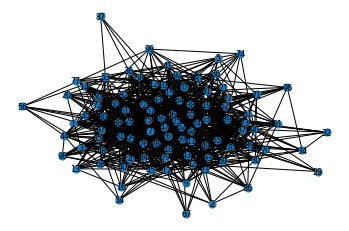

In [136]:
draw_graph(G)

Ploting epsitemic coverage

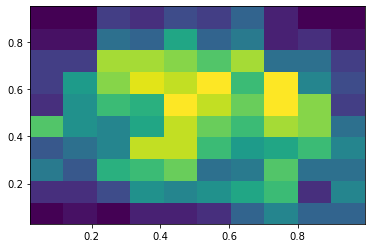

In [137]:
plot_epistemic_coverage(epistemic_coverage)

Plotting degree distribution

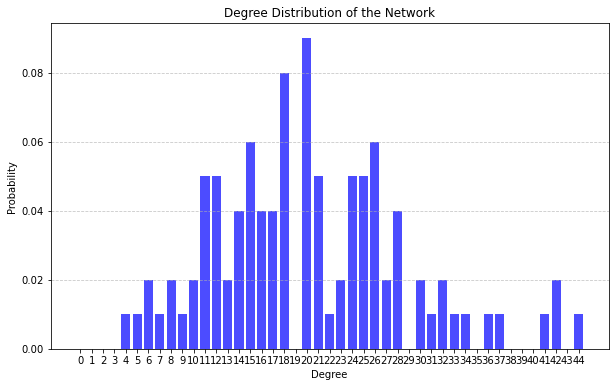

In [138]:
plot_degree_distribution(G)

## PP Model 

Collaboration and publication both depend upon mean prestige

In [182]:
G=initialize_network(number_of_authors,10)


In [183]:
epistemic_coverage=evolve_network_PP(G,epistemic_space,100,attempt_per_time_step)


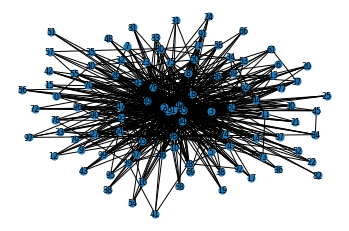

In [184]:
draw_graph(G)

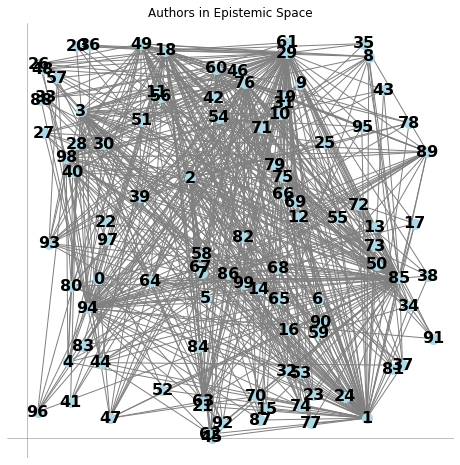

In [197]:
draw_network_in_epistemic_space(G,epistemic_space)



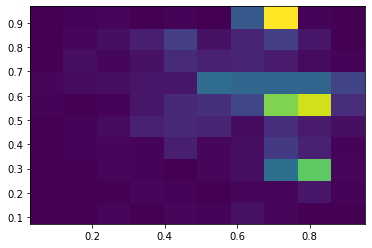

In [164]:
plot_epistemic_coverage(epistemic_coverage)

In [53]:
print(sum(list_degrees(G)),G.number_of_edges())


2510 1255


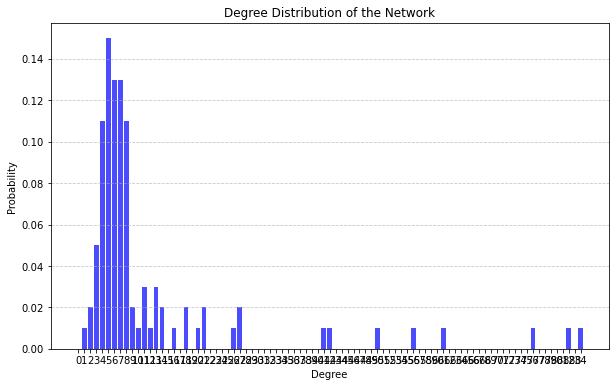

In [165]:
plot_degree_distribution(G)

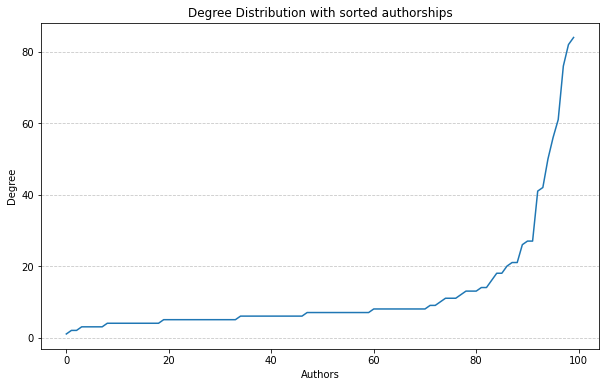

In [170]:
plot_sorted_degree_distribution(G)

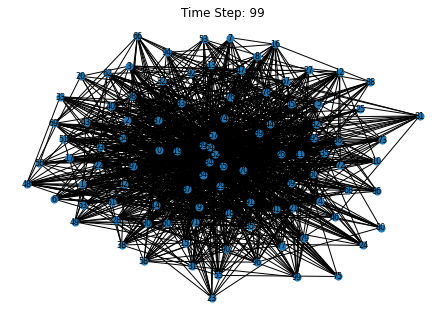

In [28]:
run_network_simulation(G,epistemic_space,time_steps,attempt_per_time_step)

## Combined Results

Function to show Degree Distribution for PP and WP models side by side

In [224]:
def degree_distribution_combined(G1,G2):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(np.sort(list_degrees(G1)))

    ax1.set_title('WP')
    ax1.set_xlabel('Authors')
    ax1.set_ylabel('# Authorships')
    ax1.grid(True)

    ax2.plot(np.sort(list_degrees(G2)))
    ax2.set_title('PP')
    ax2.set_xlabel('Authors')
    ax2.set_ylabel('# Authorships')
    ax2.grid(True)

Function to show heatmap of Epistemic Coverage for PP and WP models side by side

In [227]:
def heatmap_combined(ec1,ec2):

    x1=np.zeros(len(ec1))
    y1=np.zeros(len(ec1))
    x2=np.zeros(len(ec2))
    y2=np.zeros(len(ec2))

    for i in range(len(ec1)):
        x1[i]=ec1[i][0]
        y1[i]=ec1[i][1]

    for i in range(len(ec2)):
        x2[i]=ec2[i][0]
        y2[i]=ec2[i][1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.hist2d(x1,y1)

    ax1.set_title('WP')

    ax1.grid(True)

    ax2.hist2d(x2,y2)
    ax2.set_title('PP')

    ax2.grid(True)

Function to show Network on heatmap for PP and WP models side by side

In [255]:
def network_on_heatmap(G1,G2,epistemic_space):
    ec=epistemic_space
    x=np.zeros(len(ec))
    y=np.zeros(len(ec))
    for i in range(len(ec)):
        x[i]=ec[i][0]
        y[i]=ec[i][1]
    coordinates =ec
    pos = {i: (coordinates[i][0], coordinates[i][1]) for i in range(len(coordinates))}






    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.hist2d(x1,y1)
    nx.draw(G1, pos=pos,ax=ax1, with_labels=True, node_size=100, node_color='lightblue', font_size=16, font_color='black', font_weight='bold', edge_color='gray')
    ax1.set_title('WP')

    ax1.grid(True)

    ax2.hist2d(x2,y2)
    nx.draw(G2,pos= pos,ax=ax2, with_labels=True, node_size=100, node_color='lightblue', font_size=16, font_color='black', font_weight='bold', edge_color='gray')
    ax2.set_title('PP')

    ax2.grid(True)

Initializing variables

In [240]:
G1=initialize_network(number_of_authors,10)
G2=initialize_network(number_of_authors,10)
epistemic_space=initialize_epistemic_space(number_of_authors)

Heat map for the Epistemic space

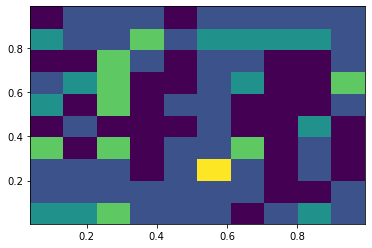

In [241]:
plot_epistemic_coverage(epistemic_space)

Evolving networks using PP and WP models

In [243]:
ec1=evolve_network_WP(G1,epistemic_space,time_steps,attempt_per_time_step)
ec2=evolve_network_PP(G2,epistemic_space,time_steps,attempt_per_time_step)

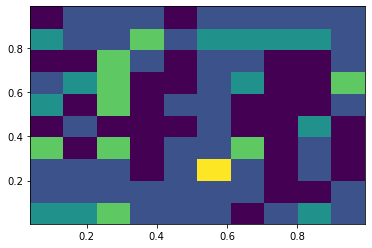

In [247]:
plot_epistemic_coverage(epistemic_space)

Degree Distribution

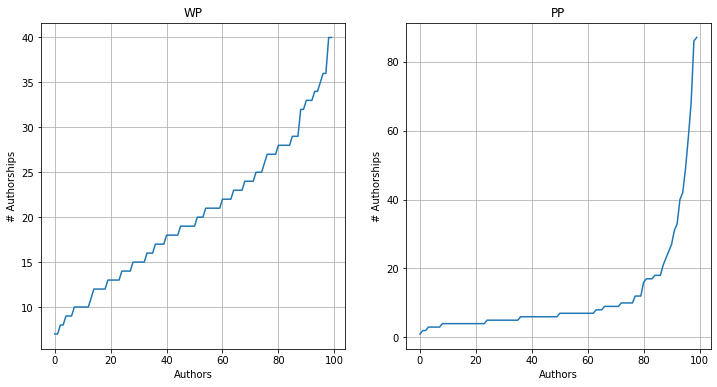

In [244]:
degree_distribution_combined(G1,G2)

Epsitemic coverage heat map

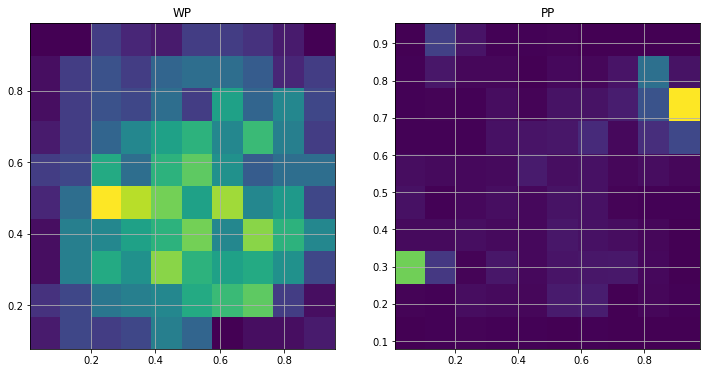

In [245]:
heatmap_combined(ec1,ec2)

Network in Epistemic space

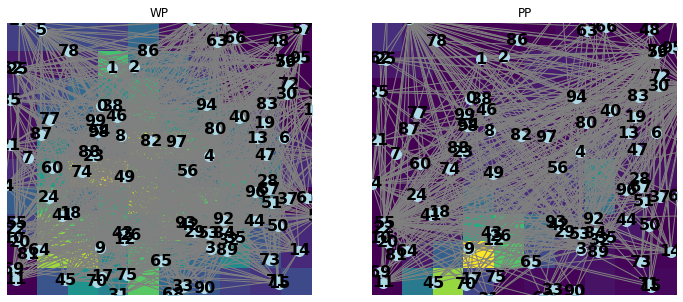

In [256]:
network_on_heatmap(G1,G2,epistemic_space)
